# Two Point Eyring Plot

**NOTE: This version of the workbook has code for more formal plots.**

This notebook will present plots of the Erying plot for the brosylates..

The data being plotted is from Figure 2 in “Neighboring Carbon and Hydrogen. VII. Reactivity of Some Alicyclic and Bicyclic Derivatives1,2,3.” 
S. Winstein, B.K. Morse, E. Grunwald, H.W. Jones, J. Corse, D. Trifan, H. Marshall, 
*J. Am. Chem. Soc.*, **1952**, *74*, 1127–1132. 
https://doi.org/10.1021/ja01125a003.

The data was digitized using WebPlotDigitizer



## Setup Tools and Read Data Table

Here the data table is read in and processed. Also the libraries are imported and any functions defined

In [1]:
### SETUP

#!pip install uncertainties
#!pip install lmfit
#!mkdir plots

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.optimize import curve_fit

import uncertainties as un
from uncertainties import unumpy as unp

import lmfit

github_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Winstein/"
github_location = ""
github_location_styles = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
github_location_LFER_tables = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"



## Read Data

Read the data in from the csv text file.

[347.65 323.15] [1.54e-04 8.16e-06] [2.e-06 6.e-08]
---------- FIT REPORT ------------
[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 2
    # variables        = 2
    chi-square         = 2.5216e-25
    reduced chi-square = 2.5216e-25
    Akaike info crit   = -110.665754
    Bayesian info crit = -113.279460
    R-squared          = 1.00000000
[[Variables]]
    m: -13135.5622 +/- 3.4364e-11 (0.00%) (init = -1000)
    b:  23.1541153 +/- 1.0457e-13 (0.00%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m, b) = -0.9995
RSQ = 1.000

      _BEST_
 m:-13135.56223
 b:  23.15412
------THERMODYNAMIC PARAMETERS----------
The change in enthalpy is 109215.14+/-0.00 J/mole 23.15411531713171+/-0.00000000000010
The change in entropy is -5.04+/-0.00 J/mole.K -13135.562231406398+/-0.000000000034

-------- CHECK FIT ----------
calculate k at T=298 K is (2.436+/-0.000)e-07
[298.15 306.85] [8.79e-0

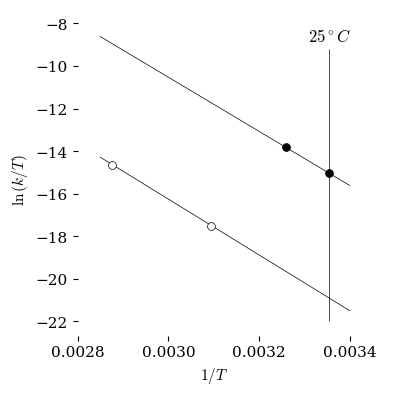

In [4]:
## EYRING PLOT
# 

import scipy.constants
size = [4,4]

sigma = 2


######################
### Experimental data with error
######################

temp_endo = np.array([74.5, 50.0]) + 273.15       # list of temperatures
k_obs_endo = np.array([15.4, 0.816]) * 1e-5  # list of observe rate constants (s^-1)
k_obs_err_endo= np.array([0.2 , 0.006]) * 1e-5  # list of standard deviations for data

temp_exo = np.array([25.0, 33.7]) + 273.15      # list of temperatures
k_obs_exo = np.array([8.79, 30.4]) * 1e-5 # list of observe rate constants (s^-1)
k_obs_err_exo= np.array([0.09 , 0.1]) * 1e-5  # list of standard deviations for data


temp = temp_endo
k_obs = k_obs_endo
k_obs_err = k_obs_err_endo

print(temp, k_obs, k_obs_err)

### Convert lists to numpy arrays (enables numpy math tools with these lists)
k_obs = unp.uarray(k_obs, k_obs_err)   # make an array of ufloat values

### Calculations for Erying plot axes
x = 1/(temp)  # convert temperature to Kelvin and then to 1/T
y_u = unp.log(k_obs/temp)   # y_u is now an array of ufloats

y = unp.nominal_values(y_u) # extract arrays of nominal values and errors
y_err = unp.std_devs(y_u)   # because curve_fit can handle ufloats

######################
###  Linear function to be used by curve_fit
######################
def linear(x, m, b):
    y = m * x + b
    return y

### Use curve_fit function  

# load the function f as the model to be fit
mod = lmfit.Model(linear)       

# state the parameters (use the text strings that we used above in the 
#   function) initial values are also set here
pars = mod.make_params(m=-1000, b=0  )     
                                            
# use the .fit method on the model object to perform the curve fit
result = mod.fit(y, pars, x=x, weights=1.0/y_err)   




print("---------- FIT REPORT ------------")
print(result.fit_report())

r,p = scipy.stats.pearsonr(x,y); rsq = r**2
print(f"RSQ = {rsq:0.3f}")
print()

#print("--- PARAMETER CONFIDENCE INTERVALS ----")
print(result.ci_report())
#print()

intercept = result.uvars['b']      # collect parameters as uncertain values 
slope = result.uvars['m']

temp_test = 298
R = scipy.constants.R
kb = scipy.constants.k
h = scipy.constants.h
kappa = 1

dH = -slope * R
dS = (intercept - unp.log(kb/h)) * R

print("------THERMODYNAMIC PARAMETERS----------")
print(f"The change in enthalpy is {dH:0.2f} J/mole {intercept}")
print(f"The change in entropy is {dS:0.2f} J/mole.K {slope}")
print()

## calculate k from Erying plot parameters.
kobs = (kappa * kb / h) * temp_test * unp.exp(-dH/(R*temp_test)) * unp.exp(dS/R)
print("-------- CHECK FIT ----------")
print(f"calculate k at T={temp_test} K is {kobs:0.4g}")


#################################################################

plt.rcdefaults()
style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(figsize = size)

ax.scatter(x, y, linewidths=0.5, marker="o", s=32, facecolors="white",
        edgecolors="black", zorder=3
)

max_x = 0.0034
min_x = 0.00285
x_fit = np.linspace(min_x, max_x, 100)  # x values for the fit line
y_fit = result.eval(x=x_fit)  # evaluate the fit line at these x values
ax.plot(x_fit, y_fit, linewidth=0.5, color="black", zorder=2)
        
##################################
### Second Exo Plot
##################################

temp = temp_exo
k_obs = k_obs_exo
k_obs_err = k_obs_err_exo

print(temp, k_obs, k_obs_err)

### Convert lists to numpy arrays (enables numpy math tools with these lists)
k_obs = unp.uarray(k_obs, k_obs_err)   # make an array of ufloat values

### Calculations for Erying plot axes
x = 1/(temp)  # convert temperature to Kelvin and then to 1/T
y_u = unp.log(k_obs/temp)   # y_u is now an array of ufloats

y = unp.nominal_values(y_u) # extract arrays of nominal values and errors
y_err = unp.std_devs(y_u)   # because curve_fit can handle ufloats

######################

### Use curve_fit function  

# load the function f as the model to be fit
mod = lmfit.Model(linear)       

# state the parameters (use the text strings that we used above in the 
#   function) initial values are also set here
pars = mod.make_params(m=-1000, b=0  )     
                                            
# use the .fit method on the model object to perform the curve fit
result = mod.fit(y, pars, x=x, weights=1.0/y_err)   




print("---------- FIT REPORT ------------")
print(result.fit_report())

r,p = scipy.stats.pearsonr(x,y); rsq = r**2
print(f"RSQ = {rsq:0.3f}")
print()

#print("--- PARAMETER CONFIDENCE INTERVALS ----")
print(result.ci_report())
#print()

intercept = result.uvars['b']      # collect parameters as uncertain values 
slope = result.uvars['m']

temp_test = 298
R = scipy.constants.R
kb = scipy.constants.k
h = scipy.constants.h
kappa = 1

dH = -slope * R
dS = (intercept - unp.log(kb/h)) * R

print("------THERMODYNAMIC PARAMETERS----------")
print(f"The change in enthalpy is {dH:0.2f} J/mole ")
print(f"The change in entropy is {dS:0.2f} J/mole.K ")
print()

## calculate k from Erying plot parameters.
kobs = (kappa * kb / h) * temp_test * unp.exp(-dH/(R*temp_test)) * unp.exp(dS/R)
print("-------- CHECK FIT ----------")
print(f"calculate k at T={temp_test} K is {kobs:0.4g}")


#################################################################

ax.scatter(x, y, linewidths=0.5, marker="o", s=32, facecolors="black",
        edgecolors="black", zorder=3
)

y_fit = result.eval(x=x_fit)  # evaluate the fit line at these x values
ax.plot(x_fit, y_fit, linewidth=0.5, color="black", zorder=2)


ax.set(xlabel = r"$1/T$",
       ylabel = r"$\ln \left( k/T \right)$"
)

ax.set_xticks([0.0028,0.0030,0.0032,0.0034])  # These will be the ticks for both axes
ax.set_xlim([0.0028, max_x])

ax.vlines(1/298.15, -22, -9.2, color='black', linewidth=0.5, zorder=1)
ax.text(1/298.15, -9, r"$25 ^\circ C$", 
        horizontalalignment='center', verticalalignment='bottom', 
        color='black', fontsize=12, zorder=1
)
##################################





### do not show legend 
fig.legend([])
plt.legend([])      # blank legend

plt.savefig("eyring.pdf")
plt.show()


In [ ]:
import scipy.constants

scipy.constants.

0.017453292519943295